# todayilearned

In [1]:
subreddit = 'todayilearned'

## Functions

### Feature Importance

In [2]:
import pandas as pd
from scripts import Munger as mg
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
import matplotlib.pyplot as plt

def feature_importance(train, test, features, predict, trees=10, state=None):
    
    X = train[features]
    y = train[predict]

    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=trees,
                                  random_state=state)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print '%d.' % (f + 1), X.columns.values[indices[f]], '(%f)' % importances[indices[f]]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), [ X.columns.values[i] for i in indices], rotation=75)
    plt.xlim([-1, X.shape[1]])
    plt.show()

    X = test[features]
    y = test[predict]

    print 'Score:', forest.score(X,y)
    
    return forest

### TFIDF Vectorization

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorize(train, test, maxdf=0.8, mindf=0.05):
    tfidf = TfidfVectorizer(stop_words='english', max_df=maxdf, min_df=mindf)

    train_tfidf = tfidf.fit_transform(train)
    test_tfidf = tfidf.transform(test)
    
    return {'train_tfidf': train_tfidf,'test_tfidf': test_tfidf}

### Clustering

In [4]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def cluster(train, test, clusters=10, iterations=300, init=10):
    km = KMeans(n_clusters=clusters, init='k-means++', max_iter=iterations, n_init=init)
    
    train_preds = km.fit_predict(train)
    test_preds = km.predict(test)
    
    return {'train_preds': train_preds, 'test_preds': test_preds}

### Full Function

In [5]:
def show_feature_importance(train_filename, test_filename, features, predict):
    # Load datasets
    train = pd.read_csv(train_filename)
    test = pd.read_csv(test_filename)
    
    
    train = train.append(test.head(350))
    test = test.tail(50)
    
    # Munge data
    train = mg.munge_dataset(train)
    test = mg.munge_dataset(test)
    
    if 'watson cluster' in features:
        # Create Watson Vector
        watson = ['Watson Anger', 'Watson Disgust', 'Watson Fear',
                   'Watson Joy', 'Watson Sadness', 'Watson Analytical',
                   'Watson Confident', 'Watson Tenative', 'Watson Openness',
                   'Watson Conscientiousness', 'Watson Extraversion',
                   'Watson Agreeableness', 'Watson Emotional Range'] 
        train_watson_vector = train[watson].values
        test_watson_vector = test[watson].values

        # Cluster by Watson Vector
        preds = cluster(train_watson_vector, test_watson_vector, 12, 300, 10)
        train['watson cluster'] = preds['train_preds']
        test['watson cluster'] = preds['test_preds']

    if 'body cluster' in features:
        # Create TFIDF vector for body
        tfidf = tfidf_vectorize(train['body'], test['body'], maxdf=0.8, mindf=0.05)
        train_tfidf = tfidf['train_tfidf']
        test_tfidf = tfidf['test_tfidf']
        
        # Cluster by Body TFIDF Vector
        preds = cluster(train_tfidf, test_tfidf, 35, 300, 10)

        train['body cluster'] = preds['train_preds']
        test['body cluster'] = preds['test_preds']

    # Map gilded to boolean
    train['gilded'] = train['gilded'].astype(bool)
    test['gilded'] = test['gilded'].astype(bool)
    
    # Print feature importance
    return feature_importance(train, test, features, predict, trees=250, state=None)

## Recursive Feature Exclusion

In [6]:
from sklearn.feature_selection import RFE

# Load datasets
train = pd.read_csv('./mytrain/added' + subreddit + '_train.csv')
test = pd.read_csv('./mytest/added' + subreddit + '_test.csv')

train = train.append(test.head(350))
test = test.tail(50)

train = mg.munge_dataset(train)
test = mg.munge_dataset(test)

# Create Watson Vector
watson = ['Watson Anger', 'Watson Disgust', 'Watson Fear',
           'Watson Joy', 'Watson Sadness', 'Watson Analytical',
           'Watson Confident', 'Watson Tenative', 'Watson Openness',
           'Watson Conscientiousness', 'Watson Extraversion',
           'Watson Agreeableness', 'Watson Emotional Range'] 
train_watson_vector = train[watson].values
test_watson_vector = test[watson].values

# Cluster by Watson Vector
preds = cluster(train_watson_vector, test_watson_vector, 12, 300, 10)
train['watson cluster'] = preds['train_preds']
test['watson cluster'] = preds['test_preds']

# Create TFIDF vector for body
tfidf = tfidf_vectorize(train['body'], test['body'], maxdf=0.8, mindf=0.05)
train_tfidf = tfidf['train_tfidf']
test_tfidf = tfidf['test_tfidf']

# Cluster by Body TFIDF Vector
preds = cluster(train_tfidf, test_tfidf, 35, 300, 10)

train['body cluster'] = preds['train_preds']
test['body cluster'] = preds['test_preds']

features = [
    'Score Bracket', 
    'Contains MD', 
    'Word Count', 
    'Time of Day', 
    'watson cluster',
    'body cluster',
    'Grammer Errors',
    'Sentiment Label',
    'Sentiment Negative',
    'Sentiment Positive',
    'Sentiment Neutral',
    'flair',
    'Watson Anger', 
    'Watson Disgust', 
    'Watson Fear',
    'Watson Joy', 
    'Watson Sadness', 
    'Watson Analytical',
    'Watson Confident', 
    'Watson Tenative', 
    'Watson Openness',
    'Watson Conscientiousness', 
    'Watson Extraversion',
    'Watson Agreeableness', 
    'Watson Emotional Range'
]

X = train[features]
y = train['gilded'].astype(bool)

X1 = test[features]
y1 = test['gilded'].astype(bool)

forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=None)
rscore = 0

for i in range(len(features)):
    rfe = RFE(estimator=forest, n_features_to_select=(len(features) - i), step=1)
    rfe.fit(X,y)
    score = rfe.score(X1, y1)
    if score > rscore:
        rscore = score
        rrfe = rfe
    
i = 0
for j in rrfe.ranking_:
    if j < 2:
        print features[i]
    i += 1
print
print 'Score:', rrfe.score(X1, y1)

Score Bracket
Word Count
body cluster
Sentiment Negative
Sentiment Positive
Sentiment Neutral
Watson Fear
Watson Joy

Score: 0.88


## Gilded Feature Analysis

Feature ranking:
1. Score Bracket (0.384708)
2. Word Count (0.146782)
3. Sentiment Neutral (0.082214)
4. Watson Joy (0.081426)
5. Watson Fear (0.080163)
6. body cluster (0.079784)
7. Sentiment Negative (0.072919)
8. Sentiment Positive (0.072003)


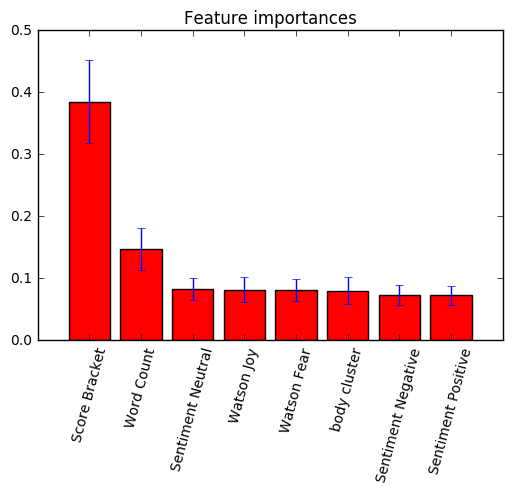

Score: 0.88


In [12]:
features = [
    'Score Bracket',
    'Word Count',
    'body cluster',
    'Sentiment Negative',
    'Sentiment Positive',
    'Sentiment Neutral',
    'Watson Fear',
    'Watson Joy',
]

gilded = show_feature_importance('./mytrain/added' + subreddit + '_train.csv', 
                        './mytest/added' + subreddit + '_test.csv', 
                        features, 
                        'gilded')

import pickle

with open("classifiers/" + subreddit + "_classifier.pickle",'wb') as f:
    pickle.dump(gilded, f) # saves classifier to file